# Terry Stops

### Business Understanding
Ethnic Fathers' of Seattle and the Seattle police chief are concerned with the impact terry stops have had on the community.

#### Stakeholder:
- Ethnic Father's of Seattle
- Seattle Police Chief/Staff
- Non-Technical stakeholder

#### True Business Problem:
In 1968 the supreme court ruled that "stop and frisk" tactics is not in violation of a person's constitutional rights. Terry v. Ohio gives a cop the ability to detain someone on the grounds of "reasonable suspicion", even with the absence of clear evidence. Based on the data from the Seattle census bureau, I was able to build multiple models that:
    - Predict if a terry stop leads to an arrest.
    - With a recent rise in racial accusations, is race a driving factor in arrest?

#### Context:
- **False Negative**: model predicts that a terry stop does not lead to an arrest, but a terry stop leads to an arrest.
    - **Outcome**:
- **False Positive**: model predicts that a terry stop does lead to an arrest, but it did not lead to an arrest.
    - **Outcome**:

## Data Understanding

In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import StrMethodFormatter

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB, GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, recall_score, roc_auc_score, plot_roc_curve
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [2]:
!ls Data

Terry_Stops.csv


In [3]:
# Load dataset
df = pd.read_csv("data/Terry_Stops.csv", na_values='-')

df.head(2)

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Reported Time,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
0,NaN,-1,20140000120677,92317,Arrest,None,7500,1984,M,Black or African American,...,11:32:00.0000000,NaN,NaN,NaN,SOUTH PCT 1ST W - ROBERT,N,N,South,O,O2
1,NaN,-1,20150000001463,28806,Field Contact,None,5670,1965,M,White,...,07:59:00.0000000,NaN,NaN,NaN,NaN,N,N,NaN,NaN,NaN


## Clean Data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52215 entries, 0 to 52214
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Subject Age Group         50446 non-null  object
 1   Subject ID                52215 non-null  int64 
 2   GO / SC Num               52215 non-null  int64 
 3   Terry Stop ID             52215 non-null  int64 
 4   Stop Resolution           52215 non-null  object
 5   Weapon Type               35740 non-null  object
 6   Officer ID                52191 non-null  object
 7   Officer YOB               52215 non-null  int64 
 8   Officer Gender            52215 non-null  object
 9   Officer Race              52215 non-null  object
 10  Subject Perceived Race    50406 non-null  object
 11  Subject Perceived Gender  51977 non-null  object
 12  Reported Date             52215 non-null  object
 13  Reported Time             52215 non-null  object
 14  Initial Call Type     

In [5]:
df.isna().sum()

Subject Age Group            1769
Subject ID                      0
GO / SC Num                     0
Terry Stop ID                   0
Stop Resolution                 0
Weapon Type                 16475
Officer ID                     24
Officer YOB                     0
Officer Gender                  0
Officer Race                    0
Subject Perceived Race       1809
Subject Perceived Gender      238
Reported Date                   0
Reported Time                   0
Initial Call Type           13465
Final Call Type             13465
Call Type                   13465
Officer Squad                 486
Arrest Flag                     0
Frisk Flag                    478
Precinct                    10161
Sector                      10389
Beat                        10306
dtype: int64

#### Filling in null values
- Definitely an easier way of doing this but I could not think of it at the time of doing this.  

In [6]:
df['Officer Squad'] = df['Officer Squad'].fillna('Unknown')
df['Weapon Type'] = df['Weapon Type'].fillna('Unknown')
df['Subject Age Group'] = df['Subject Age Group'].fillna('Unknown')
df['Officer ID'] = df['Officer ID'].fillna('0000')
df['Subject Perceived Gender'] = df['Subject Perceived Gender'].fillna('Unknown')
df['Subject Perceived Race'] = df['Subject Perceived Race'].fillna('Unknown')
df['Initial Call Type'] = df['Initial Call Type'].fillna('Unknown')
df['Final Call Type'] = df['Final Call Type'].fillna('Unknown')
df['Call Type'] = df['Call Type'].fillna('Unknown')
df['Officer Squad'] = df['Officer Squad'].fillna('Unknown')
df['Frisk Flag'] = df['Frisk Flag'].fillna('Unknown')
df['Precinct'] = df['Precinct'].fillna('Unknown')
df['Sector'] = df['Sector'].fillna('Unknown')
df['Beat'] = df['Beat'].fillna('Unknown')

In [7]:
df.isna().sum()

Subject Age Group           0
Subject ID                  0
GO / SC Num                 0
Terry Stop ID               0
Stop Resolution             0
Weapon Type                 0
Officer ID                  0
Officer YOB                 0
Officer Gender              0
Officer Race                0
Subject Perceived Race      0
Subject Perceived Gender    0
Reported Date               0
Reported Time               0
Initial Call Type           0
Final Call Type             0
Call Type                   0
Officer Squad               0
Arrest Flag                 0
Frisk Flag                  0
Precinct                    0
Sector                      0
Beat                        0
dtype: int64

#### Dropping columns & fixing column names
- Dropping columns that will not aide in making a generalized dataset or columns that are too expansive. 
- Replacing spaces and capital letters in column names

In [8]:
to_drop = ['Subject ID', 'GO / SC Num', 'Terry Stop ID', 'Stop Resolution', 'Officer ID',
           'Initial Call Type', 'Final Call Type', 'Call Type', 'Officer Squad',
           'Precinct', 'Sector', 'Beat']

In [9]:
df.drop(to_drop, axis=1, inplace=True)
df.head()

,Subject Age Group,Weapon Type,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Reported Date,Reported Time,Arrest Flag,Frisk Flag
0,Unknown,None,1984,M,Black or African American,Asian,Male,2015-10-16T00:00:00Z,11:32:00.0000000,N,N
1,Unknown,None,1965,M,White,Unknown,Unknown,2015-03-19T00:00:00Z,07:59:00.0000000,N,N
2,Unknown,None,1961,M,White,White,Male,2015-03-21T00:00:00Z,19:12:00.0000000,N,Unknown
3,Unknown,None,1963,M,White,Unknown,Unknown,2015-04-01T00:00:00Z,04:55:00.0000000,N,N
4,Unknown,None,1977,M,White,Black or African American,Male,2015-04-03T00:00:00Z,00:41:00.0000000,N,N


In [10]:
df.columns = ['subject_age_group', 'weapon_type', 'officer_YOB',
       'officer_gender', 'officer_race', 'subject_perceived_race',
       'subject_perceived_gender', 'reported_date', 'reported_time',
       'arrest_flag', 'frisk_flag']
df.columns    

Index(['subject_age_group', 'weapon_type', 'officer_YOB', 'officer_gender',
       'officer_race', 'subject_perceived_race', 'subject_perceived_gender',
       'reported_date', 'reported_time', 'arrest_flag', 'frisk_flag'],
      dtype='object')

In [11]:
df['reported_hour'] = pd.to_datetime(df['reported_time']).dt.hour

In [12]:
df['reported_month'] = pd.to_datetime(df['reported_date']).dt.month

#### Combining the arrest flag and frisk flag column into a target column. If either column indicates a yes the target column with print a Y and N otherwise.

In [13]:
df['target'] = np.where((df['frisk_flag'] == 'Y') | (df['arrest_flag'] == 'Y'), 1, 0)

In [14]:
df['target'].value_counts(normalize=True)

0    0.711232
1    0.288768
Name: target, dtype: float64

In [15]:
#sns.countplot(y='subject_age_group', data=df )

In [17]:
#minors = df[df['subject_age_group'] == '1_-_17']
#minors.head()

In [18]:
#terry_df.loc[(df['target'] == 'Yes') | (df['subject_age_group'] == '1_-_17')]

#### Looking at weapon type and arrest per weapon group.

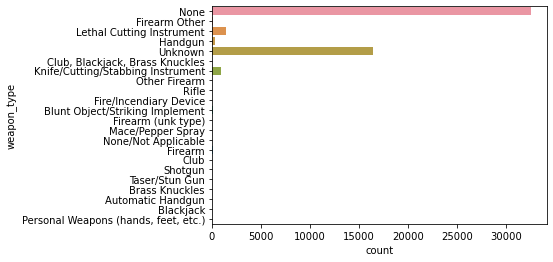

In [16]:
sns.countplot(y='weapon_type', data=df );

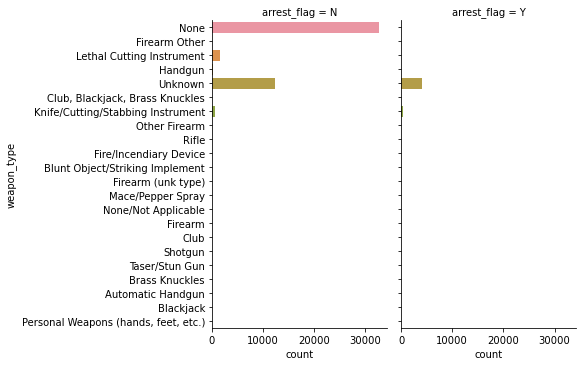

In [17]:
sns.catplot(y='weapon_type', col='arrest_flag', data=df, 
           kind='count', height=5, aspect=.8);

#### Looking at target (arrests/frisk) by age group

In [18]:
df.groupby(['subject_perceived_race'])['arrest_flag'].count() / len(df)

subject_perceived_race
American Indian or Alaska Native             0.028325
Asian                                        0.033324
Black or African American                    0.297903
Hispanic                                     0.032251
Multi-Racial                                 0.015494
Native Hawaiian or Other Pacific Islander    0.001743
Other                                        0.002911
Unknown                                      0.098784
White                                        0.489266
Name: arrest_flag, dtype: float64

In [19]:
df.groupby(['arrest_flag', 'subject_perceived_race'])['subject_age_group'].count() / len(df)

arrest_flag  subject_perceived_race                   
N            American Indian or Alaska Native             0.025950
             Asian                                        0.029551
             Black or African American                    0.267126
             Hispanic                                     0.032251
             Multi-Racial                                 0.015494
             Native Hawaiian or Other Pacific Islander    0.001264
             Other                                        0.002911
             Unknown                                      0.089878
             White                                        0.446366
Y            American Indian or Alaska Native             0.002375
             Asian                                        0.003773
             Black or African American                    0.030777
             Native Hawaiian or Other Pacific Islander    0.000479
             Unknown                                      0.008905
       

## Terry Stops by Race
- What is the % breakdown by race?
- How does that compare to Seattle census data?
    - check for proportion
    - https://www.seattle.gov/opcd/population-and-demographics/about-seattle#raceethnicity

In [20]:
df['subject_perceived_race'].value_counts(normalize=True)

White                                        0.489266
Black or African American                    0.297903
Unknown                                      0.098784
Asian                                        0.033324
Hispanic                                     0.032251
American Indian or Alaska Native             0.028325
Multi-Racial                                 0.015494
Other                                        0.002911
Native Hawaiian or Other Pacific Islander    0.001743
Name: subject_perceived_race, dtype: float64

In [21]:
race = ['White',
  'Black or African American',
  'Hispanic',
  'Asian',
  'American Indian or Alaska Native',
  'Multi-Racial']

terry_stop = [0.489, 0.298, 0.034, 0.032, 0.028, 0.016]

census = [0.645, 0.068, 0.066, 0.149, 0.005, 0.06]

arrest_frisk = [0.043, 0.031, 0.000, 0.003, 0.002, 0.000]

In [22]:
df_new_race = pd.DataFrame({'race':race,
                        'terry_stops':terry_stop,
                        'arrest_frisk': arrest_frisk,
                        'census':census}).set_index(['race'])

In [23]:
df_new_race2 = df_new_race * 100

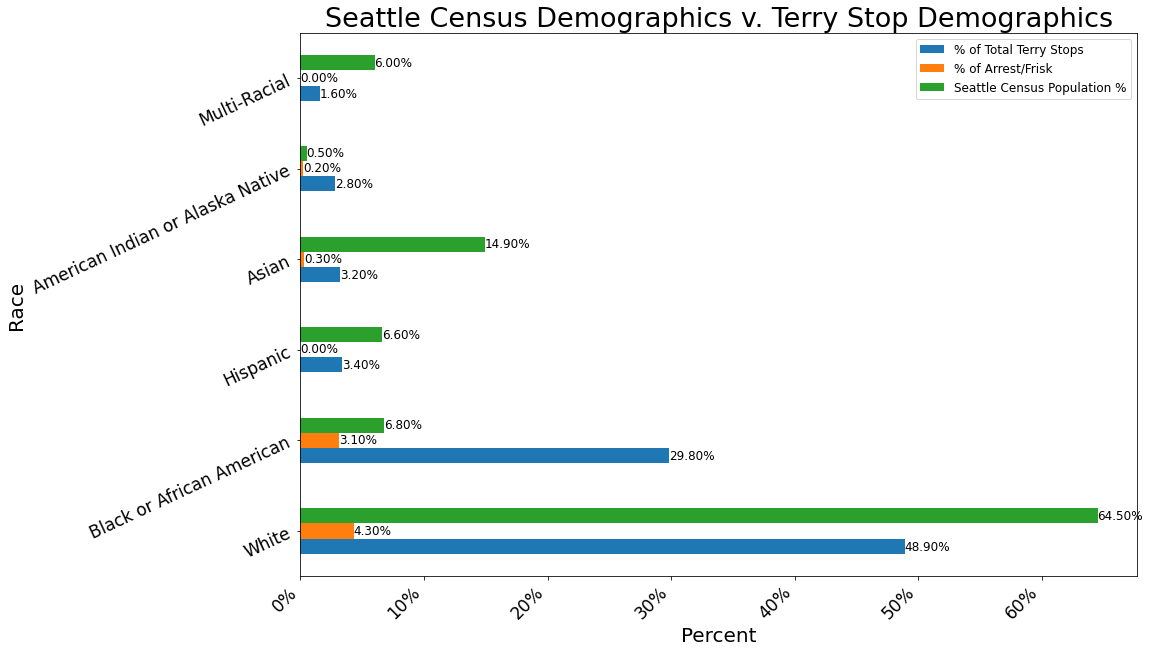

In [28]:
ax = df_new_race2.plot(kind = 'barh', figsize = (15,10))

for i, v in enumerate(df_new_race2.terry_stops):
    ax.text(v, i-.21, '{:.2f}%'.format(v),fontsize = 12)

for i, v in enumerate(df_new_race2.census):
    ax.text(v, i+.13, '{:.2f}%'.format(v),fontsize = 12)
    
for i, v in enumerate(df_new_race2['arrest_frisk']):
    ax.text(v, i-.035, '{:.2f}%'.format(v),fontsize = 12)

ax.set_title('Seattle Census Demographics v. Terry Stop Demographics', fontsize=27)
ax.set_xlabel('Percent', fontsize = 20)
ax.set_ylabel('Race', fontsize = 20)
leg = ax.legend(loc = 'best', labels = ['% of Total Terry Stops', '% of Arrest/Frisk', 'Seattle Census Population %'], fontsize = 'large')
# for text in leg.get_texts():
#     text.set_color("white")

plt.xticks(rotation = 45, ha='right', fontsize = 17)
plt.yticks(fontsize=17, rotation = 25)

# ax.xaxis.label.set_color('white')
# ax.yaxis.label.set_color('white')
# ax.title.set_color('white')


ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}%'))

plt.show()

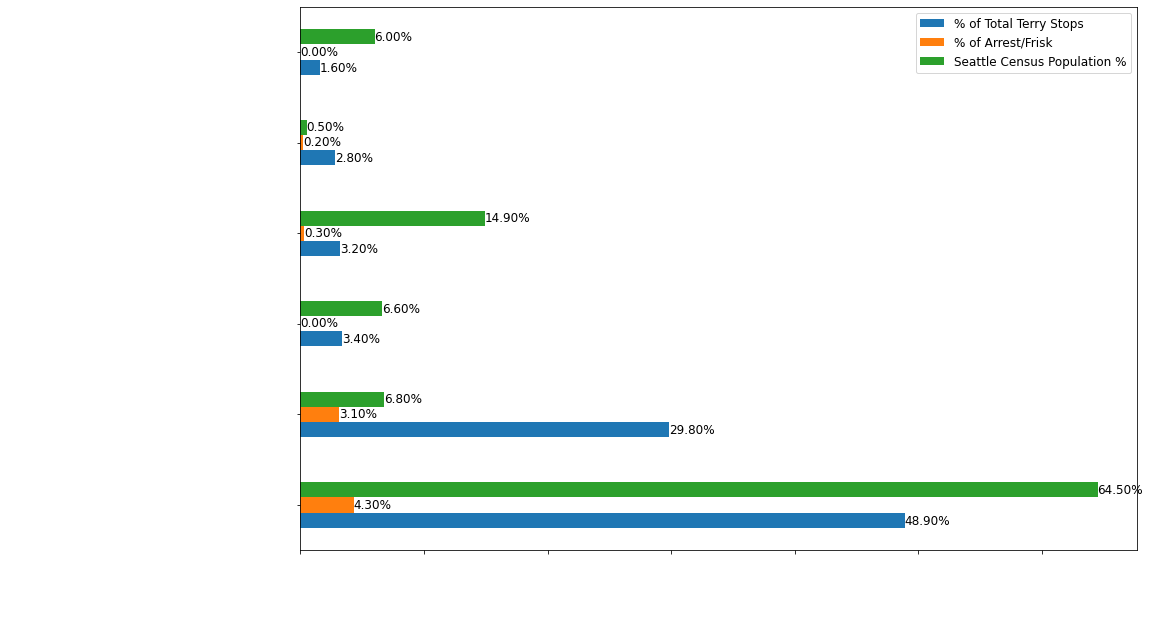

In [29]:
ax = df_new_race2.plot(kind = 'barh', figsize = (15,10))

for i, v in enumerate(df_new_race2.terry_stops):
    ax.text(v, i-.21, '{:.2f}%'.format(v),fontsize = 12)

for i, v in enumerate(df_new_race2.census):
    ax.text(v, i+.13, '{:.2f}%'.format(v),fontsize = 12)
    
for i, v in enumerate(df_new_race2['arrest_frisk']):
    ax.text(v, i-.035, '{:.2f}%'.format(v),fontsize = 12)

# ax.set_title('Seattle Census Demographics v. Terry Stop Demographics', fontsize=27)
ax.set_xlabel('Percent', fontsize = 20)
ax.set_ylabel('Race', fontsize = 20)
leg = ax.legend(loc = 'best', labels = ['% of Total Terry Stops', '% of Arrest/Frisk', 'Seattle Census Population %'], fontsize = 'large')
# for text in leg.get_texts():
#     text.set_color("white")

plt.xticks(rotation = 45, ha='right', fontsize = 17, color = 'w' )
plt.yticks(fontsize=17, rotation = 25, color = 'w')

ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.title.set_color('white')


ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}%'))

plt.show()

# Cleared the title colors for the presentation. Keeping in notebook for future reference.

In [50]:
df['subject_perceived_gender']

0           Male
1        Unknown
2           Male
3        Unknown
4           Male
          ...   
52210       Male
52211       Male
52212       Male
52213       Male
52214       Male
Name: subject_perceived_gender, Length: 52215, dtype: object

## Train-test-split

In [23]:
X = df.drop(columns = ['reported_date', 'reported_time', 'arrest_flag', 'frisk_flag', 'target'])
y = df['target']


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [24]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39161 entries, 25990 to 15795
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   subject_age_group         39161 non-null  object
 1   weapon_type               39161 non-null  object
 2   officer_YOB               39161 non-null  int64 
 3   officer_gender            39161 non-null  object
 4   officer_race              39161 non-null  object
 5   subject_perceived_race    39161 non-null  object
 6   subject_perceived_gender  39161 non-null  object
 7   reported_hour             39161 non-null  int64 
 8   reported_month            39161 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 3.0+ MB


In [25]:
X_train.head(2)

,subject_age_group,weapon_type,officer_YOB,officer_gender,officer_race,subject_perceived_race,subject_perceived_gender,reported_hour,reported_month
25990,26 - 35,Unknown,1992,M,White,Black or African American,Female,9,12
38639,36 - 45,Unknown,1994,M,White,White,Male,20,11


In [26]:
X_train.describe()

,officer_YOB,reported_hour,reported_month
count,39161.000000,39161.000000,39161.000000
mean,1983.397257,11.741912,6.398228
std,9.022672,7.208553,3.321851
min,1900.000000,0.000000,1.000000
25%,1979.000000,5.000000,4.000000
50%,1985.000000,13.000000,6.000000
75%,1990.000000,18.000000,9.000000
max,2000.000000,23.000000,12.000000


In [27]:
X_train.describe(include='O')

,subject_age_group,weapon_type,officer_gender,officer_race,subject_perceived_race,subject_perceived_gender
count,39161,39161,39161,39161,39161,39161
unique,7,21,3,9,9,5
top,26 - 35,None,M,White,White,Male
freq,13106,24451,34694,28910,19177,30793


In [28]:
for col in X_train.columns:
    display(X_train[col].value_counts())
    print("*" * 20)


26 - 35         13106
36 - 45          8429
18 - 25          7719
46 - 55          5032
56 and Above     2015
1 - 17           1537
Unknown          1323
Name: subject_age_group, dtype: int64

********************


None                                    24451
Unknown                                 12311
Lethal Cutting Instrument                1142
Knife/Cutting/Stabbing Instrument         662
Handgun                                   243
Blunt Object/Striking Implement            90
Firearm Other                              77
Firearm                                    39
Club, Blackjack, Brass Knuckles            38
Mace/Pepper Spray                          34
Other Firearm                              21
Firearm (unk type)                         13
Taser/Stun Gun                              9
Rifle                                       7
None/Not Applicable                         7
Fire/Incendiary Device                      5
Shotgun                                     4
Club                                        4
Personal Weapons (hands, feet, etc.)        2
Brass Knuckles                              1
Automatic Handgun                           1
Name: weapon_type, dtype: int64

********************


1986    2748
1987    2525
1984    2204
1991    2184
1992    2037
1990    1977
1985    1955
1988    1714
1989    1666
1982    1404
1983    1382
1979    1252
1993    1251
1995    1220
1981    1162
1971     949
1976     938
1994     923
1978     899
1977     785
1973     754
1996     691
1980     684
1967     589
1970     495
1968     490
1997     473
1969     445
1974     435
1975     414
1962     368
1972     328
1965     316
1964     312
1963     192
1961     170
1966     167
1958     154
1959     134
1960     126
1998      72
1957      34
1954      33
1953      25
1900      23
1955      16
1956      12
1999      11
1952       7
1948       6
2000       5
1949       4
1946       1
Name: officer_YOB, dtype: int64

********************


M    34694
F     4446
N       21
Name: officer_gender, dtype: int64

********************


White                            28910
Hispanic or Latino                2362
Two or More Races                 2306
Asian                             1811
Not Specified                     1619
Black or African American         1527
Nat Hawaiian/Oth Pac Islander      353
American Indian/Alaska Native      250
Unknown                             23
Name: officer_race, dtype: int64

********************


White                                        19177
Black or African American                    11690
Unknown                                       3863
Asian                                         1300
Hispanic                                      1269
American Indian or Alaska Native              1094
Multi-Racial                                   592
Other                                          115
Native Hawaiian or Other Pacific Islander       61
Name: subject_perceived_race, dtype: int64

********************


Male                                                         30793
Female                                                        7894
Unable to Determine                                            237
Unknown                                                        225
Gender Diverse (gender non-conforming and/or transgender)       12
Name: subject_perceived_gender, dtype: int64

********************


18    2348
2     2268
3     2124
19    2114
17    2043
1     1989
23    1958
16    1853
0     1803
22    1730
15    1725
14    1694
11    1616
10    1559
13    1504
21    1481
12    1251
5     1251
9     1233
4     1230
20    1179
8     1122
7     1059
6     1027
Name: reported_hour, dtype: int64

********************


5     4078
6     3700
7     3536
4     3470
10    3303
8     3277
3     3228
1     3179
9     2977
11    2919
2     2760
12    2734
Name: reported_month, dtype: int64

********************


#### One hot encoder

In [29]:
cat_cols = []
for col in X_train.columns:
    if len(X_train[col].unique()) < 10:
        cat_cols.append(col)

In [30]:
cat_cols

['subject_age_group',
 'officer_gender',
 'officer_race',
 'subject_perceived_race',
 'subject_perceived_gender']

In [31]:
cat_transformer = Pipeline(steps = [
 ('ohe', OneHotEncoder(drop='first', sparse=False))
])


In [32]:
num_cols = ['reported_hour', 'reported_month']

In [33]:
preprocessor = ColumnTransformer(transformers = [
    ('cat_trans', cat_transformer, cat_cols),
    ('num_trans', MinMaxScaler(), num_cols)
], remainder='passthrough')


In [34]:
X_train_one = X_train.drop(columns=['weapon_type', 'officer_YOB'])
X_test_one = X_test.drop(columns=['weapon_type', 'officer_YOB'])

In [35]:
X_tr_pr = preprocessor.fit_transform(X_train_one)
X_te_pr = preprocessor.transform(X_test_one)

##  Model 1: Logistic Regression
- 5 total models will be created below and the same process will followed for all.
    - Pipeline
    - Fit the data
    - Predict the train and test data
    - Print the scores
    - Plot the accurarcy curve
    - Plot the confusion matrix    

In [36]:
lrm = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('lr', LogisticRegression(max_iter=1000))
])


In [37]:
cv_results = cross_validate(lrm, X_train_one, y_train)

In [38]:
cv_results['test_score']

array([0.71390272, 0.71399387, 0.71386619, 0.71373851, 0.71386619])

In [39]:
lrm.fit(X_train_one, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_trans',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['subject_age_group',
                                                   'officer_gender',
                                                   'officer_race',
                                                   'subject_perceived_race',
                                                   'subject_perceived_gender']),
                                                 ('num_trans', MinMaxScaler(),
                                                  ['reported_hour',
                                                   'reported_mo

In [40]:
te_pred_lrm = lrm.predict(X_test_one)
tr_pred_lrm = lrm.predict(X_train_one)

train_probas_lrm = lrm.predict_proba(X_train_one)[:,1]
test_probas_lrm = lrm.predict_proba(X_test_one)[:,1]


print(f"Train F1:{f1_score(y_train, tr_pred_lrm):.4f}")
print(f"Train Precision:{precision_score(y_train, tr_pred_lrm):.4f}")
print(f"Test ROC-AUC:{roc_auc_score(y_train, train_probas_lrm):.4f}")
print("*" * 20)
print(f"Test F1:{f1_score(y_test, te_pred_lrm):.4f}")
print(f"Test Precision:{precision_score(y_test, te_pred_lrm):.4f}")
print(f"Test ROC-AUC:{roc_auc_score(y_test, test_probas_lrm):.4f}")

Train F1:0.0039
Train Precision:0.6471
Test ROC-AUC:0.5938
********************
Test F1:0.0036
Test Precision:0.5000
Test ROC-AUC:0.5924


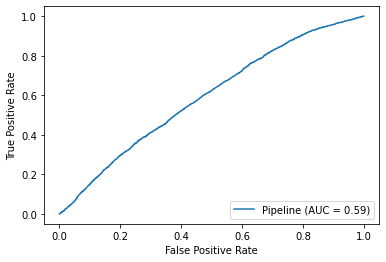

In [41]:
plot_roc_curve(lrm, X_test_one, y_test)

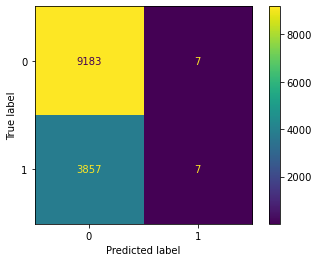

In [42]:
plot_confusion_matrix(lrm, X_test_one, y_test);

## Model 2: Decision Tree

In [43]:
dtm = Pipeline(steps = [
 ('preprocessor', preprocessor),
 ('dt', DecisionTreeClassifier())
])

dtm.fit(X_train_one, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_trans',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['subject_age_group',
                                                   'officer_gender',
                                                   'officer_race',
                                                   'subject_perceived_race',
                                                   'subject_perceived_gender']),
                                                 ('num_trans', MinMaxScaler(),
                                                  ['reported_hour',
                                                   'reported_mo

In [44]:
te_pred_dt = dtm.predict(X_test_one)
tr_pred_dt = dtm.predict(X_train_one)

train_probas_dt = dtm.predict_proba(X_train_one)[:,1]
test_probas_dt = dtm.predict_proba(X_test_one)[:,1]


print(f"Train F1:{f1_score(y_train, tr_pred_dt):.4f}")
print(f"Train Precision:{precision_score(y_train, tr_pred_dt):.4f}")
print(f"Test ROC-AUC:{roc_auc_score(y_train, train_probas_dt):.4f}")
print("*" * 20)
print(f"Test F1:{f1_score(y_test, te_pred_dt):.4f}")
print(f"Test Precision:{precision_score(y_test, te_pred_dt):.4f}")
print(f"Test ROC-AUC:{roc_auc_score(y_test, test_probas_dt):.4f}")

Train F1:0.6719
Train Precision:0.8862
Test ROC-AUC:0.9266
********************
Test F1:0.2777
Test Precision:0.3552
Test ROC-AUC:0.5475


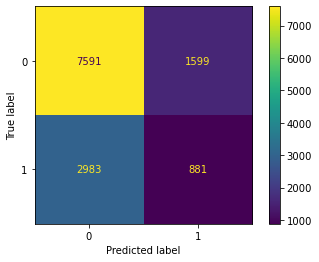

In [45]:
plot_confusion_matrix(dtm, X_test_one, y_test);

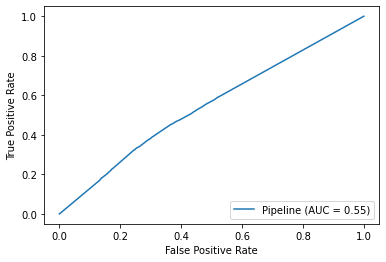

In [46]:
plot_roc_curve(dtm, X_test_one, y_test);


## Model 3: KNN

In [47]:
knn = Pipeline(steps = [
 ('preprocessor', preprocessor),
 ('knn', KNeighborsClassifier())
])

knn.fit(X_train_one, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_trans',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['subject_age_group',
                                                   'officer_gender',
                                                   'officer_race',
                                                   'subject_perceived_race',
                                                   'subject_perceived_gender']),
                                                 ('num_trans', MinMaxScaler(),
                                                  ['reported_hour',
                                                   'reported_mo

In [48]:
te_pred_knn = knn.predict(X_test_one)
tr_pred_knn = knn.predict(X_train_one)

train_probas_knn = knn.predict_proba(X_train_one)[:,1]
test_probas_knn = knn.predict_proba(X_test_one)[:,1]


print(f"Train F1:{f1_score(y_train, tr_pred_knn):.4f}")
print(f"Train Precision:{precision_score(y_train, tr_pred_knn):.4f}")
print(f"Test ROC-AUC:{roc_auc_score(y_train, train_probas_knn):.4f}")
print("*" * 20)
print(f"Test F1:{f1_score(y_test, te_pred_knn):.4f}")
print(f"Test Precision:{precision_score(y_test, te_pred_knn):.4f}")
print(f"Test ROC-AUC:{roc_auc_score(y_test, test_probas_knn):.4f}")


Train F1:0.4543
Train Precision:0.6097
Test ROC-AUC:0.7627
********************
Test F1:0.2682
Test Precision:0.3681
Test ROC-AUC:0.5509


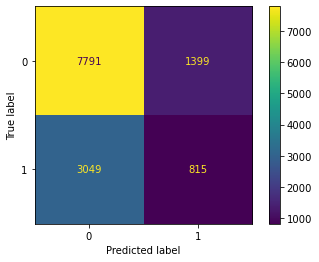

In [49]:
plot_confusion_matrix(knn, X_test_one, y_test);

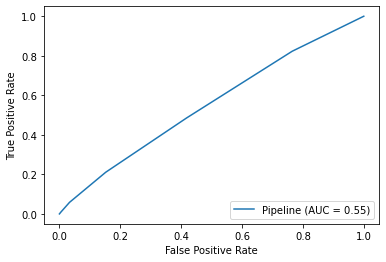

In [50]:
plot_roc_curve(knn, X_test_one, y_test);

## Model 4: Naive Bays

In [51]:
nb = Pipeline(steps = [
 ('preprocessor', preprocessor),
 ('nb', MultinomialNB())
])

nb.fit(X_train_one, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_trans',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['subject_age_group',
                                                   'officer_gender',
                                                   'officer_race',
                                                   'subject_perceived_race',
                                                   'subject_perceived_gender']),
                                                 ('num_trans', MinMaxScaler(),
                                                  ['reported_hour',
                                                   'reported_mo

In [52]:
te_pred_nb = nb.predict(X_test_one)
tr_pred_nb = nb.predict(X_train_one)

train_probas_nb = nb.predict_proba(X_train_one)[:,1]
test_probas_nb = nb.predict_proba(X_test_one)[:,1]


print(f"Train F1:{f1_score(y_train, tr_pred_nb):.4f}")
print(f"Train Precision:{precision_score(y_train, tr_pred_nb):.4f}")
print(f"Test ROC-AUC:{roc_auc_score(y_train, train_probas_nb):.4f}")
print("*" * 20)
print(f"Test F1:{f1_score(y_test, te_pred_nb):.4f}")
print(f"Test Precision:{precision_score(y_test, te_pred_nb):.4f}")
print(f"Test ROC-AUC:{roc_auc_score(y_test, test_probas_nb):.4f}")

Train F1:0.0012
Train Precision:0.7778
Test ROC-AUC:0.5740
********************
Test F1:0.0026
Test Precision:0.8333
Test ROC-AUC:0.5724


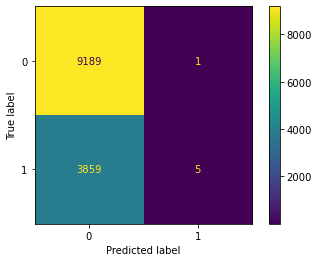

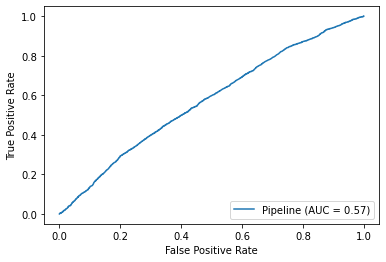

In [53]:
plot_confusion_matrix(nb, X_test_one, y_test);

plot_roc_curve(nb, X_test_one, y_test);

## Model 5: Random Forest

In [54]:
rf = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier())
])

rf.fit(X_train_one, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_trans',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['subject_age_group',
                                                   'officer_gender',
                                                   'officer_race',
                                                   'subject_perceived_race',
                                                   'subject_perceived_gender']),
                                                 ('num_trans', MinMaxScaler(),
                                                  ['reported_hour',
                                                   'reported_mo

In [55]:
te_pred_rf = rf.predict(X_test_one)
tr_pred_rf = rf.predict(X_train_one)

train_probas_rf = rf.predict_proba(X_train_one)[:,1]
test_probas_rf = rf.predict_proba(X_test_one)[:,1]


print(f"Train F1:{f1_score(y_train, tr_pred_rf):.4f}")
print(f"Train Precision:{precision_score(y_train, tr_pred_rf):.4f}")
print(f"Test ROC-AUC:{roc_auc_score(y_train, train_probas_rf):.4f}")
print("*" * 20)
print(f"Test F1:{f1_score(y_test, te_pred_rf):.4f}")
print(f"Test Precision:{precision_score(y_test, te_pred_rf):.4f}")
print(f"Test ROC-AUC:{roc_auc_score(y_test, test_probas_rf):.4f}")

Train F1:0.6924
Train Precision:0.8286
Test ROC-AUC:0.9198
********************
Test F1:0.2847
Test Precision:0.3812
Test ROC-AUC:0.5654


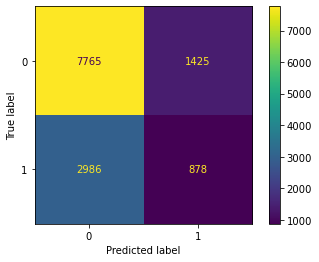

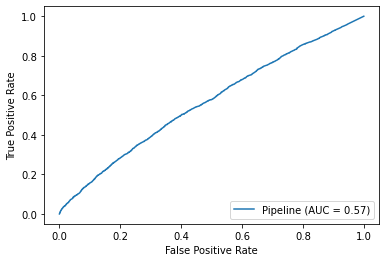

In [56]:
plot_confusion_matrix(rf, X_test_one, y_test);

plot_roc_curve(rf, X_test_one, y_test);

Because of Decision Trees perform better with data that dependent upon people, DT can better capture the interactions.

# Model Tuning
- GridSearchCV will be used to tune the hyperparameters to maximize model performance.
- Tuning the trees to get a better accuracy score. 
    - I follow the same steps as above.
    - Add some parameters using a param_grid.
    - Pull the parameters and use them with my model.

In [57]:
dt2 = Pipeline(steps = [
 ('preprocessor', preprocessor),
 ('dt', DecisionTreeClassifier(random_state = 200))
])

dt2.fit(X_train_one, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_trans',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['subject_age_group',
                                                   'officer_gender',
                                                   'officer_race',
                                                   'subject_perceived_race',
                                                   'subject_perceived_gender']),
                                                 ('num_trans', MinMaxScaler(),
                                                  ['reported_hour',
                                                   'reported_mo

In [58]:
dt2_param_grid = {
    'dt__criterion': ['gini', 'entropy'],
    'dt__max_depth': [3, 5, 7, 10, 15],
    'dt__max_features': ['auto', 'sqrt', 'log2'],
    'dt__min_samples_leaf': [5, 14, 20, 50]
}

In [59]:
# Initialize the grid search object with five-fold cross-validation
gs = GridSearchCV(dt2, dt2_param_grid, cv = 5, scoring = 'roc_auc', verbose =True )

# Then fit it to our X_train and y_train
gs.fit(X_train_one, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:  1.9min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat_trans',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse=False))]),
                                                                         ['subject_age_group',
                                                                          'officer_gender',
                                                                          'officer_race',
                                                                          'subject_perceived_race',
                                          

In [60]:
gs.best_params_

{'dt__criterion': 'gini',
 'dt__max_depth': 15,
 'dt__max_features': 'auto',
 'dt__min_samples_leaf': 50}

In [61]:
gs.best_score_

0.580503688877786

In [62]:
gs.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_trans',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['subject_age_group',
                                                   'officer_gender',
                                                   'officer_race',
                                                   'subject_perceived_race',
                                                   'subject_perceived_gender']),
                                                 ('num_trans', MinMaxScaler(),
                                                  ['reported_hour',
                                                   'reported_mo

In [63]:
te_pred_dt2 = gs.best_estimator_.predict(X_test_one)
tr_pred_dt2 = gs.best_estimator_.predict(X_train_one)

train_probas_dt2 = gs.best_estimator_.predict_proba(X_train_one)[:,1]
test_probas_dt2 = gs.best_estimator_.predict_proba(X_test_one)[:,1]


print(f"Train F1:{f1_score(y_train, tr_pred_dt2):.4f}")
print(f"Train Precision:{precision_score(y_train, tr_pred_dt2):.4f}")
print(f"Train ROC-AUC:{roc_auc_score(y_train, train_probas_dt2):.4f}")
print("*" * 20)
print(f"Test F1:{f1_score(y_test, te_pred_dt2):.4f}")
print(f"Test Precision:{precision_score(y_test, te_pred_dt2):.4f}")
print(f"Test ROC-AUC:{roc_auc_score(y_test, test_probas_dt2):.4f}")

Train F1:0.0288
Train Precision:0.5220
Train ROC-AUC:0.6062
********************
Test F1:0.0256
Test Precision:0.4016
Test ROC-AUC:0.5834


Looking at the features that are influecing scores and the level of importance of those features.

In [68]:
dt_feat_import = gs.best_estimator_.named_steps['dt'].feature_importances_

In [65]:
ohe_col_names = gs.best_estimator_.named_steps['preprocessor'].named_transformers_['cat_trans']['ohe'].get_feature_names()

In [66]:
output_cols = [*ohe_col_names, *num_cols]
len(output_cols)

30

In [67]:
{k: v for k, v in sorted(dict(zip(output_cols, dt_feat_import)).items(), key=lambda item: item[1], reverse=True)}

{'x4_Male': 0.4081805663365922,
 'x3_White': 0.15829884914444814,
 'reported_hour': 0.11613120319585388,
 'reported_month': 0.1014255825086613,
 'x3_Black or African American': 0.03522053653324326,
 'x3_Asian': 0.020420731353304845,
 'x2_Two or More Races': 0.018540913812910814,
 'x3_Hispanic': 0.01791086476218219,
 'x1_M': 0.016959815488082793,
 'x0_18 - 25': 0.016836021262625993,
 'x3_Unknown': 0.016177857034250957,
 'x2_White': 0.013330207471675725,
 'x3_Multi-Racial': 0.01184240727284559,
 'x0_26 - 35': 0.011414125432288987,
 'x2_Asian': 0.006520733629436489,
 'x2_Black or African American': 0.006296413499937955,
 'x0_46 - 55': 0.005401895690788706,
 'x2_Not Specified': 0.00504481892197474,
 'x0_36 - 45': 0.004418659429903626,
 'x0_Unknown': 0.004022960445617844,
 'x0_56 and Above': 0.003832924618142335,
 'x2_Hispanic or Latino': 0.0017719121552315729,
 'x1_N': 0.0,
 'x2_Nat Hawaiian/Oth Pac Islander': 0.0,
 'x2_Unknown': 0.0,
 'x3_Native Hawaiian or Other Pacific Islander': 0.0,
 

## RF

In [69]:
rf2 = Pipeline(steps = [
 ('preprocessor', preprocessor),
 ('rf', RandomForestClassifier(random_state = 200))
])

rf2.fit(X_train_one, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_trans',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['subject_age_group',
                                                   'officer_gender',
                                                   'officer_race',
                                                   'subject_perceived_race',
                                                   'subject_perceived_gender']),
                                                 ('num_trans', MinMaxScaler(),
                                                  ['reported_hour',
                                                   'reported_mo

In [70]:
rf2.score(X_test_one, y_test)

0.664087635973648

In [71]:
y_pred = rf2.predict(X_test_one)

In [72]:
accuracy_score(y_pred, y_test)

0.664087635973648

In [74]:
rf2_param_grid = {
    'rf__n_estimators': [400, 500],
    'rf__max_features': [5, 15],
    'rf__max_depth': [8, 10]
}

In [75]:
# Initialize the grid search object with five-fold cross-validation
gs2 = GridSearchCV(rf2, rf2_param_grid, cv = 5)

# Then fit it to our X_train and y_train
gs2.fit(X_train_one, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat_trans',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse=False))]),
                                                                         ['subject_age_group',
                                                                          'officer_gender',
                                                                          'officer_race',
                                                                          'subject_perceived_race',
                                          

In [76]:
gs2.best_params_

{'rf__max_depth': 8, 'rf__max_features': 15, 'rf__n_estimators': 400}

In [77]:
gs2.best_score_

0.7137458177973888

In [78]:
gs2.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_trans',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['subject_age_group',
                                                   'officer_gender',
                                                   'officer_race',
                                                   'subject_perceived_race',
                                                   'subject_perceived_gender']),
                                                 ('num_trans', MinMaxScaler(),
                                                  ['reported_hour',
                                                   'reported_mo

In [194]:
te_pred_rf2 = gs2.best_estimator_.predict(X_test_one)
tr_pred_rf2 = gs2.best_estimator_.predict(X_train_one)

train_probas_rf2 = gs2.best_estimator_.predict_proba(X_train_one)[:,1]
test_probas_rf2 = gs2.best_estimator_.predict_proba(X_test_one)[:,1]


print(f"Train F1:{f1_score(y_train, tr_pred_rf2):.4f}")
print(f"Train Precision:{precision_score(y_train, tr_pred_rf2):.4f}")
print(f"Train ROC-AUC:{roc_auc_score(y_train, train_probas_rf2):.4f}")
print("*" * 20)
print(f"Test F1:{f1_score(y_test, te_pred_rf2):.4f}")
print(f"Test Precision:{precision_score(y_test, te_pred_rf2):.4f}")
print(f"Test ROC-AUC:{roc_auc_score(y_test, test_probas_rf2):.4f}")

Train F1:0.0069
Train Precision:0.9512
Train ROC-AUC:0.6466
********************
Test F1:0.0031
Test Precision:0.4286
Test ROC-AUC:0.6037


## BOOST
An `AdaBoost` will be used to combine multiple weak classifiers to build a strong classifier. The group of classifiers can learn from the previous classifiers wrongly classified datapoints.  

In [80]:
ada = Pipeline(steps = [
 ('preprocessor', preprocessor),
 ('ada', AdaBoostClassifier(random_state = 42,
                            learning_rate = .1,
                            n_estimators = 100))
])

ada.fit(X_train_one, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_trans',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['subject_age_group',
                                                   'officer_gender',
                                                   'officer_race',
                                                   'subject_perceived_race',
                                                   'subject_perceived_gender']),
                                                 ('num_trans', MinMaxScaler(),
                                                  ['reported_hour',
                                                   'reported_mo

In [81]:
ada.score(X_test_one, y_test)

0.7039987743220468

In [82]:
ada.score(X_train_one, y_train)

0.7136436761063303

In [83]:
ada_feat_import = ada.named_steps['ada'].feature_importances_

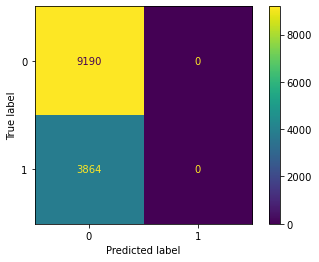

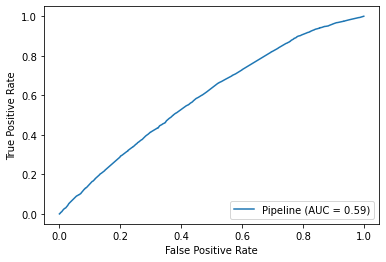

In [182]:
plot_confusion_matrix(ada, X_test_one, y_test);

plot_roc_curve(ada., X_test_one, y_test);

In [84]:
{k: v for k, v in sorted(dict(zip(output_cols, ada_feat_import)).items(), key=lambda item: item[1], reverse=True)}

{'x4_Male': 0.22,
 'x3_White': 0.15,
 'reported_hour': 0.14,
 'x3_Hispanic': 0.08,
 'reported_month': 0.08,
 'x2_Two or More Races': 0.06,
 'x3_Black or African American': 0.06,
 'x3_Multi-Racial': 0.05,
 'x0_Unknown': 0.04,
 'x0_46 - 55': 0.03,
 'x0_18 - 25': 0.02,
 'x1_M': 0.02,
 'x2_Not Specified': 0.02,
 'x3_Native Hawaiian or Other Pacific Islander': 0.02,
 'x3_Asian': 0.01,
 'x0_26 - 35': 0.0,
 'x0_36 - 45': 0.0,
 'x0_56 and Above': 0.0,
 'x1_N': 0.0,
 'x2_Asian': 0.0,
 'x2_Black or African American': 0.0,
 'x2_Hispanic or Latino': 0.0,
 'x2_Nat Hawaiian/Oth Pac Islander': 0.0,
 'x2_Unknown': 0.0,
 'x2_White': 0.0,
 'x3_Other': 0.0,
 'x3_Unknown': 0.0,
 'x4_Gender Diverse (gender non-conforming and/or transgender)': 0.0,
 'x4_Unable to Determine': 0.0,
 'x4_Unknown': 0.0}

In [86]:
cat_cols
#  x0: 'subject_age_group',
#  x1: 'officer_gender',
#  x2: 'officer_race',
#  x3: 'subject_perceived_race',
#  x4: 'subject_perceived_gender

['subject_age_group',
 'officer_gender',
 'officer_race',
 'subject_perceived_race',
 'subject_perceived_gender']

# Conclusion
The data showed that race and gender played a major factor in a person being arrested or frisked. Whites account 64.5% of Seattle population and 48.9% of the terry stops but only 4.3% of the arrest or frisk. On the other hand, Asians account for 14.9% of Seattle population and 3.2% of the total terry stops, but 30% of their terry stop population end in arrest or frisk. Whites have the highest total population and highest terry stop percentage, even after combining all the other races' total numbers, but they account for the one of the lowest arrest or frisked numbers.